# Regression

## Objectives

* To build and evaluate predictive models that accurately estimate house sale prices in Ames, Iowa, helping Lydia Doe make informed pricing decisions for her inherited properties.


## Inputs

* outputs/datasets/cleaned/house_prices_cleaned.csv
* Target variable: `SalePrice`

## Outputs

* Trained regression models
* Model evaluation metrics (R², MAE, RMSE)
* Actual vs Predicted visualizations
* Best-performing saved model



---

# Change working directory

In [1]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Load Data

In [2]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
      # variables we will not need for this project
      )

print(df.shape)
df.head(3)


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


## Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# MP Pipeline: Regressor

## Create ML pipeline

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

# Custom Class for hyperparameter optimisation

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches



## Split Train Test Set

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [6]:
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [7]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [8]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804695,0.874444,0.07442
2,RandomForestRegressor,0.632989,0.785848,0.85964,0.08142
0,LinearRegression,0.700438,0.783795,0.819273,0.044047
5,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652
4,AdaBoostRegressor,0.621051,0.727258,0.794948,0.066443
6,XGBRegressor,0.516199,0.711484,0.828932,0.112389
1,DecisionTreeRegressor,0.495511,0.63295,0.726995,0.077708


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [10]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
7,GradientBoostingRegressor,0.668948,0.766232,0.850032,0.07875,0.01,3,300
0,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652,0.1,3,100
1,GradientBoostingRegressor,0.627949,0.741072,0.825227,0.079915,0.1,3,300
9,GradientBoostingRegressor,0.569657,0.731759,0.837156,0.089336,0.01,10,300
2,GradientBoostingRegressor,0.548797,0.725966,0.823137,0.094328,0.1,10,100
3,GradientBoostingRegressor,0.548598,0.725364,0.822807,0.094218,0.1,10,300
11,GradientBoostingRegressor,0.546619,0.688758,0.796302,0.084754,0.01,None,300
4,GradientBoostingRegressor,0.512955,0.674419,0.781933,0.093606,0.1,None,100
5,GradientBoostingRegressor,0.512936,0.674411,0.781926,0.093611,0.1,None,300
8,GradientBoostingRegressor,0.613347,0.667288,0.748431,0.044308,0.01,10,100


Check the best model

In [12]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [13]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [14]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


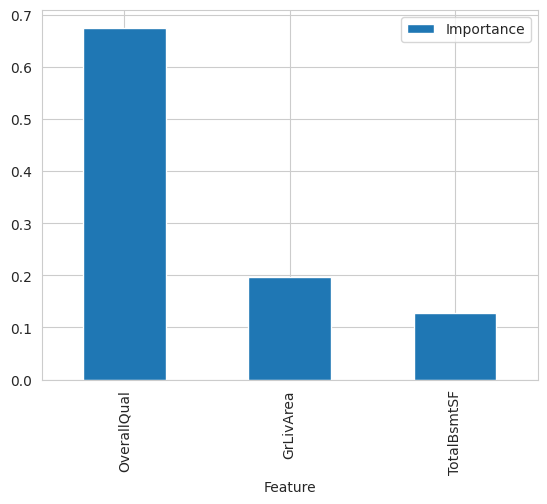

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.862
Mean Absolute Error: 20885.9
Mean Squared Error: 848097702.071
Root Mean Squared Error: 29122.117


* Test Set
R2 Score: 0.833
Mean Absolute Error: 21925.546
Mean Squared Error: 1152875378.152
Root Mean Squared Error: 33954.019




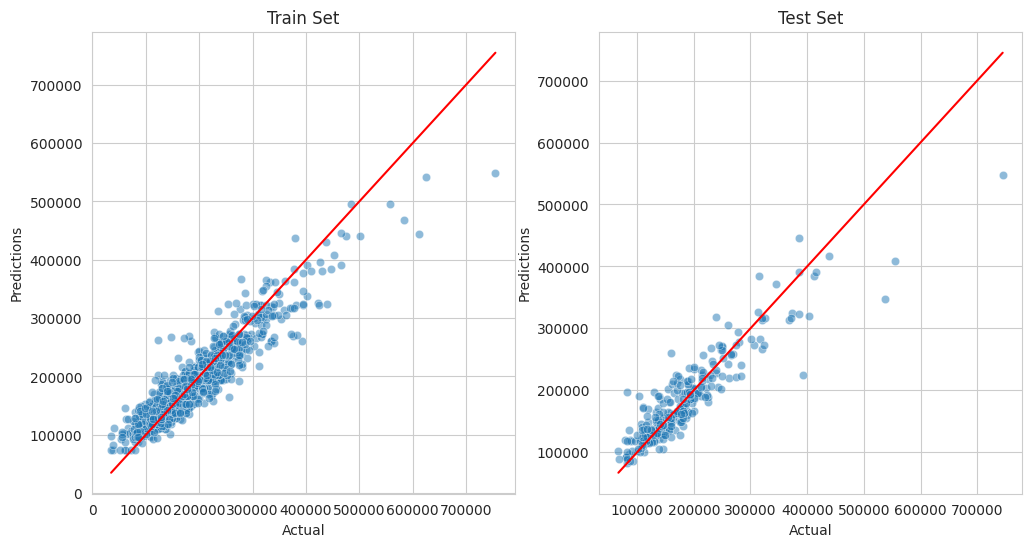

In [17]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [18]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 17 components explain 100.0% of the data 



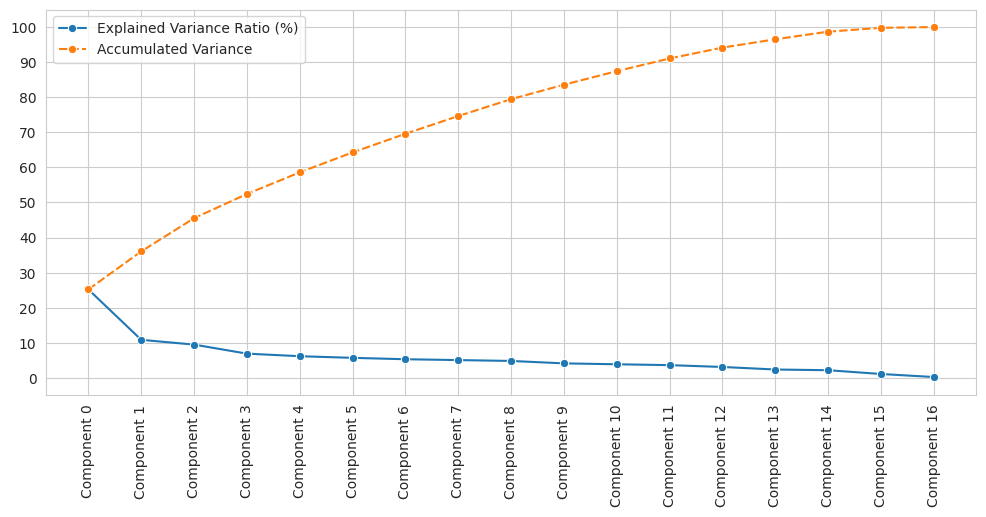

In [19]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 8 components explain 74.62% of the data 



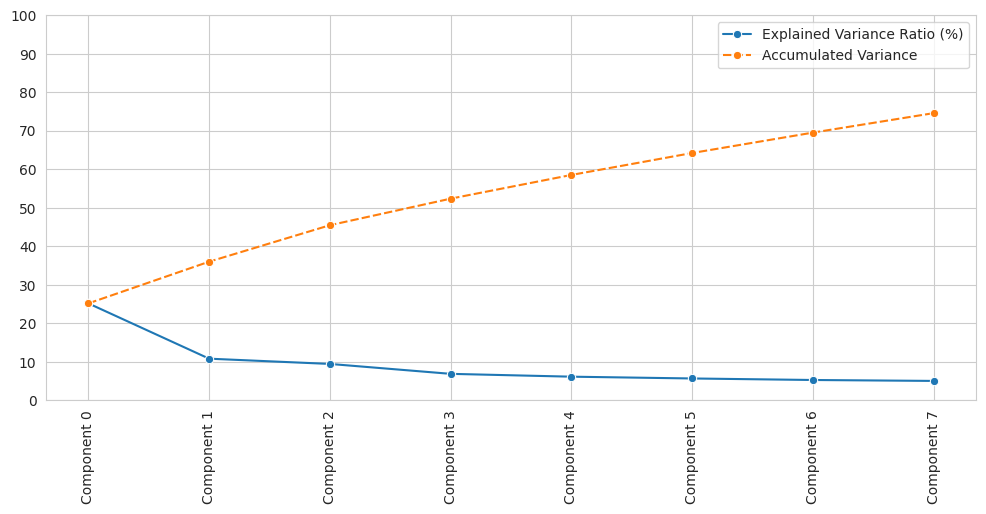

In [20]:
n_components = 8
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [21]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [22]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Use standard hyperparameters to find the most suitable model.

In [23]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [24]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [25]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.723499,0.76841,0.80392,0.0354
3,ExtraTreesRegressor,0.632353,0.756972,0.820373,0.071552
0,LinearRegression,0.665615,0.743441,0.781792,0.044411
5,GradientBoostingRegressor,0.625964,0.743202,0.806959,0.070841
6,XGBRegressor,0.632752,0.734817,0.787178,0.058974
4,AdaBoostRegressor,0.649668,0.717199,0.765622,0.040909
1,DecisionTreeRegressor,0.374887,0.578911,0.684701,0.107449


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [26]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [27]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingRegressor,0.625964,0.743202,0.806959,0.070841,0.1,3,100
7,GradientBoostingRegressor,0.660002,0.740865,0.789318,0.045151,0.01,3,300
1,GradientBoostingRegressor,0.605477,0.733874,0.802151,0.077382,0.1,3,300
9,GradientBoostingRegressor,0.518216,0.689084,0.764369,0.087509,0.01,10,300
3,GradientBoostingRegressor,0.494819,0.671818,0.754848,0.094036,0.1,10,300
2,GradientBoostingRegressor,0.494852,0.671797,0.754821,0.094009,0.1,10,100
8,GradientBoostingRegressor,0.587079,0.641452,0.695926,0.041635,0.01,10,100
6,GradientBoostingRegressor,0.590097,0.635037,0.672544,0.029514,0.01,3,100
11,GradientBoostingRegressor,0.439972,0.605329,0.700014,0.088008,0.01,None,300
10,GradientBoostingRegressor,0.552487,0.603278,0.645099,0.034528,0.01,None,100


Check the best model

In [29]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [30]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor

In [31]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', GradientBoostingRegressor(random_state=0))])

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.929
Mean Absolute Error: 15104.531
Mean Squared Error: 435467939.776
Root Mean Squared Error: 20867.869


* Test Set
R2 Score: 0.832
Mean Absolute Error: 21655.044
Mean Squared Error: 1163099028.93
Root Mean Squared Error: 34104.238




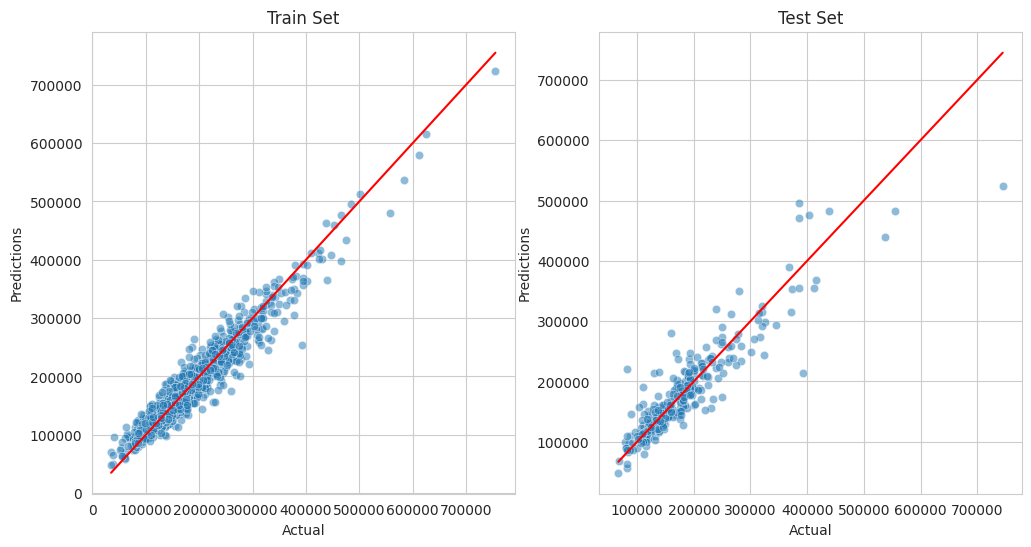

In [32]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'SalePrice': [-inf, 129975.0, 163000.0, 214000.0, inf]} 



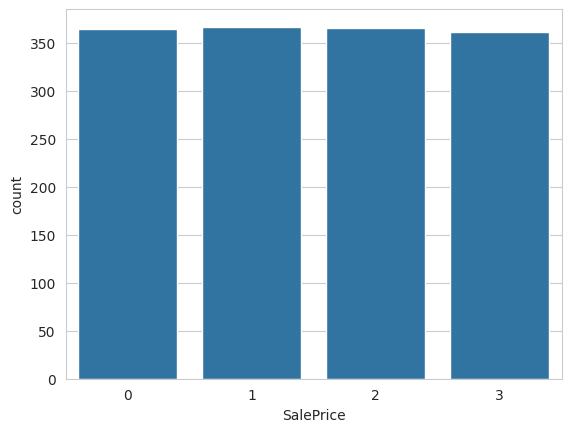

In [33]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=4, variables=['SalePrice'])
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='SalePrice')
plt.show()

In [34]:
df_clf.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,2
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,2
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,3


## Rewrite ML Pipeline for Modelling

In [64]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [65]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [67]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [68]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [69]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,GradientBoostingClassifier,0.724138,0.768966,0.827586,0.043069
5,AdaBoostClassifier,0.62069,0.765517,0.862069,0.090316
2,RandomForestClassifier,0.689655,0.762069,0.810345,0.048029
4,ExtraTreesClassifier,0.62069,0.737931,0.793103,0.06302
0,XGBClassifier,0.62069,0.7,0.758621,0.045747
1,DecisionTreeClassifier,0.62069,0.672414,0.706897,0.030842


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [70]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


Extensive GridSearch CV

In [71]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Check results

In [72]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
6,AdaBoostClassifier,0.948276,0.97931,1.0,0.020107,0.001,50
7,AdaBoostClassifier,0.793103,0.944828,1.0,0.078178,0.001,100
8,AdaBoostClassifier,0.793103,0.834483,0.931034,0.051839,0.001,300
3,AdaBoostClassifier,0.775862,0.831034,0.931034,0.054956,0.01,50
4,AdaBoostClassifier,0.62069,0.672414,0.793103,0.068966,0.01,100
2,AdaBoostClassifier,0.413793,0.596552,0.758621,0.111524,0.1,300
1,AdaBoostClassifier,0.241379,0.4,0.465517,0.088856,0.1,100
5,AdaBoostClassifier,0.206897,0.337931,0.517241,0.104932,0.01,300
0,AdaBoostClassifier,0.206897,0.306897,0.465517,0.092141,0.1,50



Check the best model

In [73]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Parameters for best model
* We are saving this content for later

In [74]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

Define the best clf pipeline

In [75]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

* These are the 8 most important features in descending order. The model was trained on them: 
['OverallQual', 'BsmtFinSF1', 'KitchenQual', 'GrLivArea', 'LotArea', 'OverallCond', 'TotalBsmtSF', 'YearBuilt']


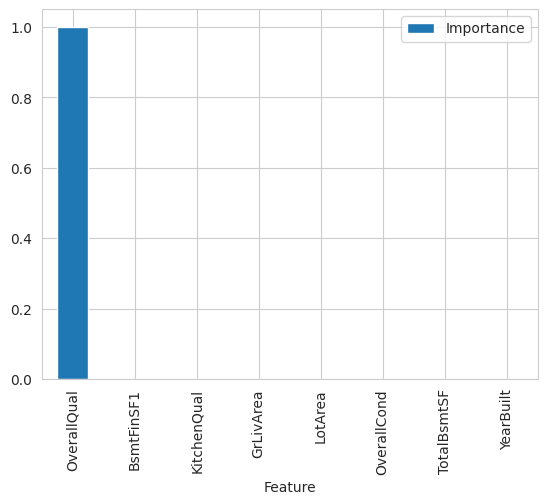

In [76]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [77]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and SalePrice interval

In [78]:
disc.binner_dict_['SalePrice']

[-inf, 129975.0, 163000.0, 214000.0, inf]

We can create manually

In [79]:
label_map = ['Low', 'Medium', 'High', 'Premium']
label_map

['Low', 'Medium', 'High', 'Premium']

In [80]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                   Actual Low Actual Medium Actual High Actual Premium
Prediction Low            286           264         151             33
Prediction Medium           0             0           0              0
Prediction High             0             0           0              0
Prediction Premium          4            33         132            265


---  Classification Report  ---
              precision    recall  f1-score   support

         Low       0.39      0.99      0.56       290
      Medium       0.00      0.00      0.00       297
        High       0.00      0.00      0.00       283
     Premium       0.61      0.89      0.72       298

    accuracy                           0.47      1168
   macro avg       0.25      0.47      0.32      1168
weighted avg       0.25      0.47      0.32      1168
 

#### Test Set ####

---  Confusion Matrix  ---
                   Actual Low Actual Medium Actual High Actual Premium
Predict

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/p

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

In [81]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

# Refit pipeline with best features

## Rewrite Pipeline

In [82]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),
        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Subset Best Features

In [84]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 8) (1168,) 
* Test set: (292, 8) (292,)


,OverallQual,BsmtFinSF1,KitchenQual,GrLivArea,LotArea,OverallCond,TotalBsmtSF,YearBuilt
618,9,48,Gd,1828,11694,5,1822,2007
870,5,0,TA,894,6600,5,894,1962
92,5,713,TA,964,13360,7,876,1921


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [85]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [86]:
best_parameters

{'model__learning_rate': 0.001, 'model__n_estimators': 50}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [87]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.001],
  'model__n_estimators': [50]}}

GridSearch CV

In [88]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [89]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostClassifier,0.948276,0.986207,1.0,0.020107,0.001,50


Check the best model

In [90]:
best_model = grid_search_summary.iloc[0,0]
best_model

'AdaBoostClassifier'

Define the best clf pipeline

In [91]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

## Assess feature importance

* These are the 8 most important features in descending order. The model was trained on them: 
['OverallQual', 'BsmtFinSF1', 'KitchenQual', 'GrLivArea', 'LotArea', 'OverallCond', 'TotalBsmtSF', 'YearBuilt']


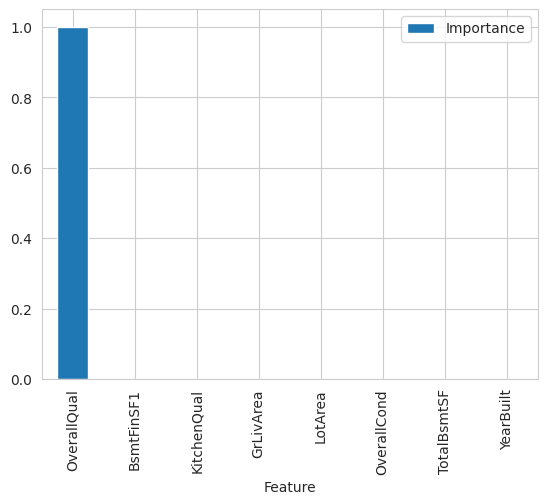

In [92]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [93]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                   Actual Low Actual Medium Actual High Actual Premium
Prediction Low            286           264         151             33
Prediction Medium           0             0           0              0
Prediction High             0             0           0              0
Prediction Premium          4            33         132            265


---  Classification Report  ---
              precision    recall  f1-score   support

         Low       0.39      0.99      0.56       290
      Medium       0.00      0.00      0.00       297
        High       0.00      0.00      0.00       283
     Premium       0.61      0.89      0.72       298

    accuracy                           0.47      1168
   macro avg       0.25      0.47      0.32      1168
weighted avg       0.25      0.47      0.32      1168
 

#### Test Set ####

---  Confusion Matrix  ---
                   Actual Low Actual Medium Actual High Actual Premium
Predict

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cistudent/.local/lib/p

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [94]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [95]:
X_train.head()

,OverallQual,BsmtFinSF1,KitchenQual,GrLivArea,LotArea,OverallCond,TotalBsmtSF,YearBuilt
618,9,48,Gd,1828,11694,5,1822,2007
870,5,0,TA,894,6600,5,894,1962
92,5,713,TA,964,13360,7,876,1921
817,8,1218,Gd,1689,13265,5,1568,2002
302,7,0,Gd,1541,13704,5,1541,2001


In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [96]:
y_train

618     3
870     0
92      2
817     3
302     2
       ..
763     3
835     0
1216    0
559     3
684     3
Name: SalePrice, Length: 1168, dtype: int64

In [97]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [98]:
X_test.head()

,OverallQual,BsmtFinSF1,KitchenQual,GrLivArea,LotArea,OverallCond,TotalBsmtSF,YearBuilt
529,6,1219,TA,2515,32668,3,2035,1957
491,6,403,Fa,1578,9490,7,806,1941
459,5,185,Gd,1203,7015,4,709,1950
279,7,392,TA,2022,10005,5,1160,1977
655,6,0,TA,1092,1680,5,525,1971


In [99]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [100]:
y_test

529     2
491     1
459     0
279     2
655     0
       ..
326     3
440     3
1387    1
1323    0
61      0
Name: SalePrice, Length: 292, dtype: int64

In [101]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting SalePrice

In [102]:
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostClassifier(learning_rate=0.001, random_state=0))])

In [103]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/clf_pipeline.pkl']

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [104]:
label_map

['Low', 'Medium', 'High', 'Premium']

In [105]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

['outputs/ml_pipeline/predict_SalePrice/v1/label_map.pkl']

## Feature importance plot

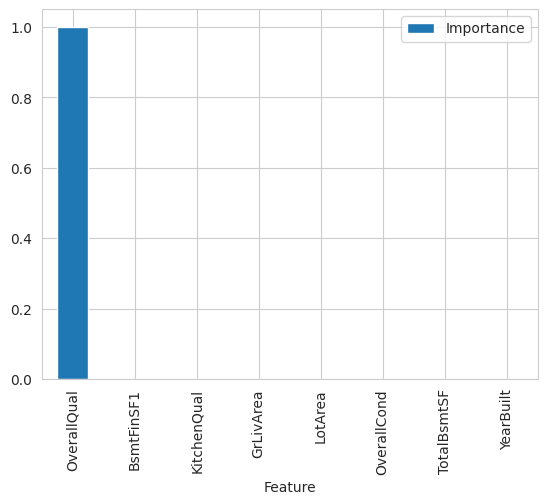

In [106]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

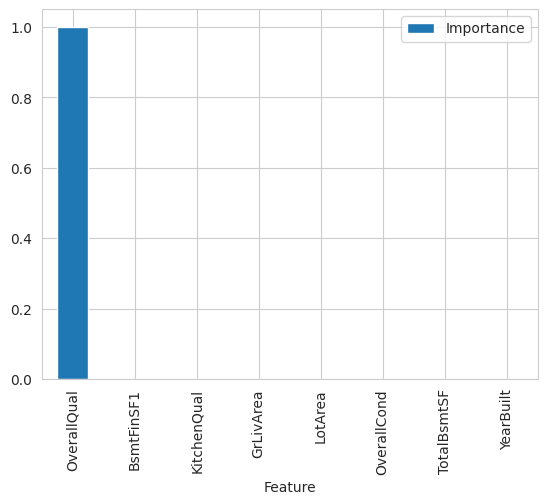

In [107]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---